In [55]:
import numpy as np 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from config import config
from data_handling import unpickle
from image_feature_extraction import load_images, label_names_extraction, even_instances
import matplotlib.pyplot as plt
import os
%matplotlib inline

#### Note - dataset normalized vs. non-normalized
In the report, one can see the results coming from a normalized and not normalized data (before feeding to the neural network). The variable that controls it here is dataset_normalized. If one needs to read in the non-normalized version, just set it to false here or in a config.ini file. However, this assumes that the data is already generated. To generate non-normalized data, one should run a python script cnn_codes.py after changing the value in config.ini file. 
<br>
In this report, only values for normalized data will be presented. 

In [56]:
dataset_normalized = config['dataset_details']['network_normalized']
path_restricted_dataset = config['paths']['restricted_dataset_path']
    path_features_network = config['paths']['network_representations']
else: 
    path_features_network = config['paths']['network_representations'] + "_not_normalized"
content_features_network = unpickle(path_features_network)
meta_classes = label_names_extraction(os.path.join(path_restricted_dataset, config['dataset_details']['class_info']))


#original with labels
train_data = content_features_network['train']
train_labels = content_features_network['train_labels']
test_data = content_features_network['test']
test_labels = content_features_network['test_labels']

In [57]:
#map train labels
mapped_train_labels = [meta_classes[x] for x in train_labels]
mapped_test_labels = [meta_classes[x] for x in test_labels]

### Visualization of CNN Codes
Here, I will visualize the features of CNN projected into two dimensions. I will use two dimensionality reduction techniques: PCA and TSNE (the first one, since it is standard and the second one, as it is also a common practice in CNNs, e.g. here: https://cs.stanford.edu/people/karpathy/cnnembed/).
<br>
Furthermore, I will explore how much variance is explained by the two dimensions nad I will try to reduce the data feature vector to not lose meaningful information, but also to speed up the computations in the final round. 

In [58]:
def reduce_dimensionality(input_data, n_dim, mode):
    if mode=='tsne':
        reducer = TSNE(n_components=n_dim, verbose=1)
    if mode=='pca':
        reducer = PCA(n_components=n_dim, random_state=42)
        x = reducer.fit(input_data)
        print("Explained variance ratio for PCA:", np.sum(x.explained_variance_ratio_))
    reduced_data = reducer.fit_transform(input_data)
    return reduced_data

def visualize_results(data, labels, class_names, mode, n_dim=2, colors=None, reduce=False, limits=False):
    if reduce:
        viz_data = reduce_dimensionality(data, n_dim, mode)
    else:
        viz_data = data
    if colors==None:
        colors = {x: np.random.rand(3,1) for x in class_names.keys()}
    plt.figure(figsize=(13,9))
    for label in class_names.keys():
        ind = np.where(labels == label)[0]
        plt.scatter(viz_data[ind,0], viz_data[ind,1], label=class_names[label], color=colors[label][:,0])
    plt.legend(class_names.values(), mode='expand', ncol=10)
    if limits:
        plt.xlim(-10,10)
        plt.ylim(-10,10)
    plt.xlabel("First component")
    plt.ylabel("Second component")
    plt.title(mode)
    plt.grid()
    plt.show()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_data)

colors = {x: np.random.rand(3,1) for x in meta_classes.keys()}
pca_data = reduce_dimensionality(scaled_data, 2, 'pca')


Explained variance ratio for PCA: 0.031590809375929514


### PCA Visualization

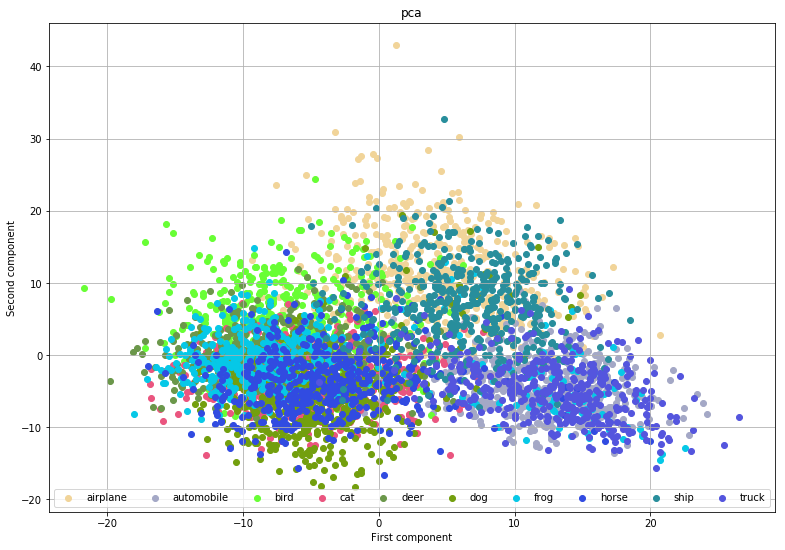

In [59]:
visualize_results(pca_data, train_labels, meta_classes, 'pca', colors=colors)

### tSNE visualization

In [60]:
tsne_data = reduce_dimensionality(scaled_data, 2, 'tsne')


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 1.710s...
[t-SNE] Computed neighbors for 5000 samples in 94.054s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 115.116905
[t-SNE] Error after 1000 iterations: 3.124601


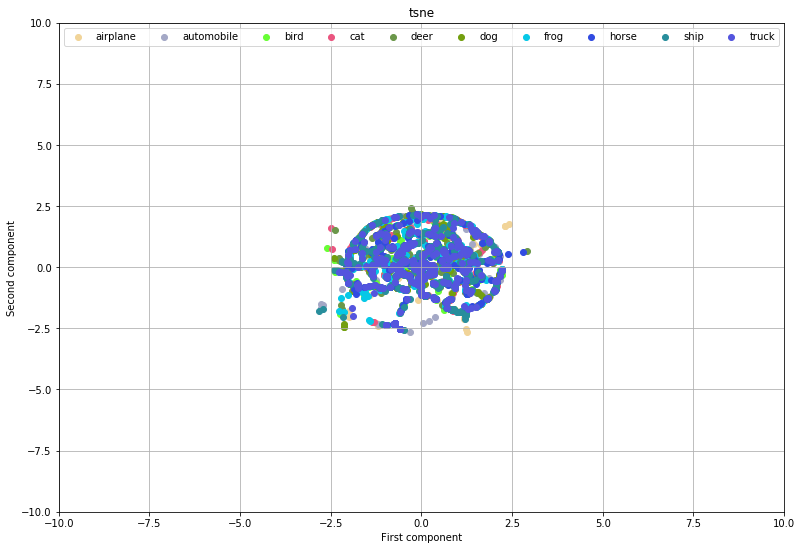

In [61]:
visualize_results(tsne_data, train_labels, meta_classes, mode='tsne', colors=colors, limits=True)

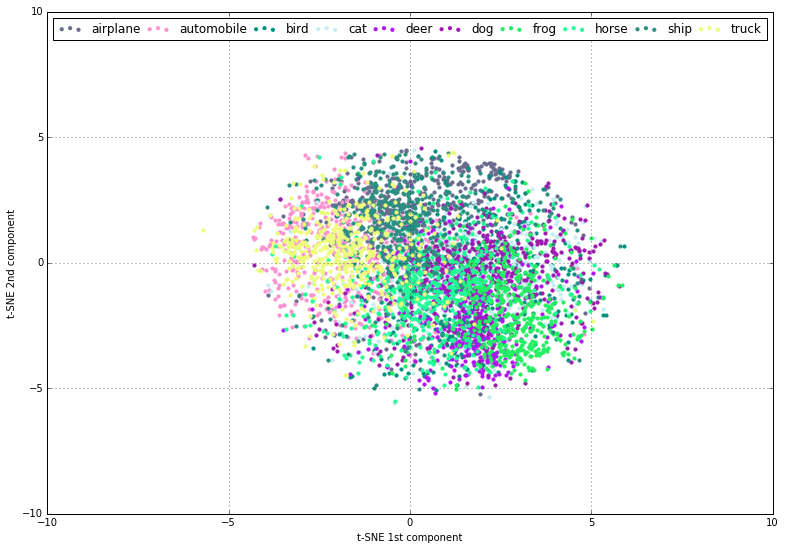

In [7]:
# plt.figure(figsize=(13,9))
# for label in meta_classes.keys():
#     ind = np.where(train_labels == label)[0]
#     plt.scatter(tsne_data[ind,0], tsne_data[ind,1], label=meta_classes[label], color=colors[label], s=10)
# plt.legend(meta_classes.values(), mode='expand', ncol=10)
# plt.xlim(-10,10)
# plt.ylim(-10,10)
# plt.xlabel("t-SNE 1st component")
# plt.ylabel("t-SNE 2nd component")
# plt.grid()
# plt.show()

### Train the SVM classifier on top of the CNN Codes
In this exercise, I will train the classifier on top of the retrieved CNN Codes. Since I have access to limited computing resources, I will use only linear kernel and check 3 values for gamma and C. Of course, the parameters could be further tuned.

In [43]:
###FINAL CLASSIFICATION
#1.5hours run
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import time

def parameter_tuning_svm(params, data, labels, cv=5, n_jobs=3):
    start = time.time()
    svm = SVC(kernel='linear')
    gridsearch = GridSearchCV(svm, params, cv=cv, n_jobs=n_jobs, scoring='accuracy', verbose=2)
    gridsearch.fit(data, labels)
    best_params = gridsearch.best_params_
    best_score = gridsearch.best_score_
    stop = time.time()
    print("Execution finished in {}".format(stop-start))
    print("Best parameters: {}".format(best_params))
    print("Best performance: {}".format(best_score))
    return best_params, best_score

parameters = {'gamma': [1e-1,1e-3, 1e-5],'C': [1, 10, 100]}
params,score = parameter_tuning_svm(parameters, scaled_data, train_labels)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 27.5min
[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed: 34.5min finished


Execution finished in 2138.2724199295044
Best parameters: {'C': 1, 'gamma': 0.1}
Best performance: 0.7362


In [47]:
#final prediction
def evaluate_classifier(clf, train_data, train_labels, test_data, test_labels):
    clf = clf
    clf.fit(train_data, train_labels)
    pred = clf.predict(test_data)
    print(classification_report(test_labels, pred))
    return pred 


clf = SVC(kernel='linear', gamma=params['gamma'], C=params['C'])
scaled_test_data = scaler.transform(test_data)
preds = evaluate_classifier(clf, scaled_data, train_labels, scaled_test_data, test_labels)
# final_SVM = SVC(kernel='linear', C=c, gamma=gamma)
# final_SVM.fit(scaled_data, train_labels)
# predictions = final_SVM.predict(scaled_test_data)

#printing results
# print(classification_report(test_labels, predictions))

             precision    recall  f1-score   support

          0       0.74      0.77      0.75       100
          1       0.82      0.84      0.83       100
          2       0.69      0.63      0.66       100
          3       0.69      0.65      0.67       100
          4       0.73      0.74      0.74       100
          5       0.70      0.74      0.72       100
          6       0.71      0.82      0.76       100
          7       0.82      0.70      0.76       100
          8       0.87      0.83      0.85       100
          9       0.77      0.83      0.80       100

avg / total       0.76      0.76      0.75      1000



In [14]:
#check for tsne
start = time.time()
parameters = {'gamma': [1e-1,1e-3, 1e-5],'C': [1, 10, 100]}
svm_tsne = SVC(kernel='linear')
gridsearch_tsne = GridSearchCV(svm_tsne, parameters, cv=5, n_jobs=3, scoring='accuracy', verbose=2)
gridsearch_tsne.fit(tsne_data, train_labels)
best_params = gridsearch_tsne.best_params_
prediction_score = gridsearch_tsne.best_score_
stop = time.time()
print("Execution finished in {}".format(stop-start))
print("Best parameters: {}".format(best_params))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] gamma=0.1, C=1 ..................................................
[CV] gamma=0.1, C=1 ..................................................
[CV] gamma=0.1, C=1 ..................................................
[CV] ................................... gamma=0.1, C=1, total=   2.0s
[CV] gamma=0.1, C=1 ..................................................
[CV] ................................... gamma=0.1, C=1, total=   2.0s
[CV] gamma=0.1, C=1 ..................................................
[CV] ................................... gamma=0.1, C=1, total=   2.2s
[CV] gamma=0.001, C=1 ................................................
[CV] ................................... gamma=0.1, C=1, total=   1.8s
[CV] ................................... gamma=0.1, C=1, total=   1.8s
[CV] gamma=0.001, C=1 ................................................
[CV] gamma=0.001, C=1 ................................................
[CV] ............

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  4.1min


[CV] ................................. gamma=0.1, C=100, total= 1.8min
[CV] gamma=0.001, C=100 ..............................................
[CV] ............................... gamma=0.001, C=100, total= 1.4min
[CV] gamma=0.001, C=100 ..............................................
[CV] ............................... gamma=0.001, C=100, total= 1.6min
[CV] gamma=1e-05, C=100 ..............................................
[CV] ............................... gamma=0.001, C=100, total= 1.7min
[CV] gamma=1e-05, C=100 ..............................................
[CV] ............................... gamma=1e-05, C=100, total= 1.5min
[CV] gamma=1e-05, C=100 ..............................................
[CV] ............................... gamma=0.001, C=100, total= 1.8min
[CV] gamma=1e-05, C=100 ..............................................
[CV] ............................... gamma=1e-05, C=100, total= 1.4min
[CV] gamma=1e-05, C=100 ..............................................
[CV] .

[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed:  9.2min finished


Execution finished in 559.6199510097504
Best parameters: {'gamma': 0.1, 'C': 10}


In [15]:
#final prediction

c = best_params["C"]
gamma = best_params["gamma"]
test_tsne = reduce_dimensionality(scaled_test_data, 2, 'tsne')
final_SVM_tsne = SVC(kernel='linear', C=c, gamma=gamma)
final_SVM_tsne.fit(tsne_data, train_labels)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.249s...
[t-SNE] Computed neighbors for 1000 samples in 10.509s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 13.908108
[t-SNE] KL divergence after 250 iterations with early exaggeration: 154.930206
[t-SNE] Error after 1000 iterations: 4.007007


NameError: name 'test_tsme' is not defined

In [16]:
predictions_tsne = final_SVM_tsne.predict(test_tsne)

#printing results
print(classification_report(test_labels, predictions_tsne))

             precision    recall  f1-score   support

          0       0.01      0.04      0.02       100
          1       0.14      0.03      0.05       100
          2       0.00      0.00      0.00       100
          3       0.11      0.06      0.08       100
          4       0.05      0.04      0.04       100
          5       0.00      0.00      0.00       100
          6       0.09      0.20      0.13       100
          7       0.03      0.01      0.02       100
          8       0.07      0.04      0.05       100
          9       0.29      0.76      0.42       100

avg / total       0.08      0.12      0.08      1000



/Users/admin/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
